# Twitter and Reddit posts analysis on the subject of Cryptocurrencies
#### Author: Ramón Hinojosa A01382300

Cryptocurrencies are digital assets for exchange between individuals. They are decentralized assets as they do not require a central authority to manage them, thus, like other exchanges, questions arise over it about which types of forces may influence its movement. 

The beginning of 2021 has gifted us with examples where social media influences the stock market and the cryptocurrency one, such as the GameStop case, or Elon Musk’s tweets about cryptocurrency investment, respectively. 

The present papers approaches a sentiment analysis on post published on the Twitter and Reddit platforms, to see its interactions with the cryptocurrency market. 

There being hundreds of crypto assets, this paper only focuses on three: Bitcoin, Ethereum, and Litecoin. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from functions import set_df, normality_test, unit_root_test, durbin_watson_test
import time
from copy import copy

import statsmodels.api as sm

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
# For plotting purposes
markers = [
    'o', 'v', 's', 'p', '*', 
    'D', ',', '+', 'x', '_', 
    '|', '^', '.', 'h', '1',
    '>',
]

In [51]:
df = pd.read_csv("cryptos_sentiment.csv")
df["index"] = pd.to_datetime( df["index"] )
df.set_index(["crypto", "index"], inplace = True)

In [52]:
aux = df.pop("leadnet")
df["leadnet"] = aux

df.sort_index(level = 1, inplace = True)

df.head()

,,replies_count_Twitter,retweets_count_Twitter,likes_count_Twitter,sentimiento_Twitter,comentarios_Reddit,score_Reddit,upvote_ratio_Reddit,sentimiento_titulo_Reddit,sentimiento_texto_Reddit,Volume,H-L,net,leadnet
crypto,index,,,,,,,,,,,,,
ethereum,2021-02-28,38737.0,43098.0,292522.0,3259.952393,778.0,3553.0,40.20,0.6447,15.7668,1.319665e+06,0.126587,0.052923,0.094095
bitcoin,2021-03-01,117142.0,173573.0,1089224.0,7987.280372,0.0,0.0,0.00,0.0000,0.0000,8.470644e+04,0.099888,0.058134,-0.001092
ethereum,2021-03-01,36554.0,51360.0,281816.0,3732.452688,412.0,1022.0,34.96,1.3707,9.2543,1.117555e+06,0.128390,0.094095,-0.023344
bitcoin,2021-03-02,99490.0,175474.0,873794.0,7641.111772,0.0,0.0,0.00,0.0000,0.0000,5.967005e+04,0.056377,-0.001092,-0.000817
ethereum,2021-03-02,36859.0,58349.0,312102.0,3794.395788,673.0,3884.0,43.74,7.2760,12.5516,9.918913e+05,0.094344,-0.023344,-0.001590


In [53]:
df.rename(columns={
    "sentimiento_Twitter":"sentiment_Twitter",
    "sentimiento_titulo_Reddit":"title_sentiment_Reddit",
    "sentimiento_texto_Reddit":"text_sentiment_Reddit",
    "comentarios_Reddit":"comments_Reddit",
    "net":"pastnet"
}, inplace = True)

## 1. Lead Net Returns distributions over Social Media Sentiment

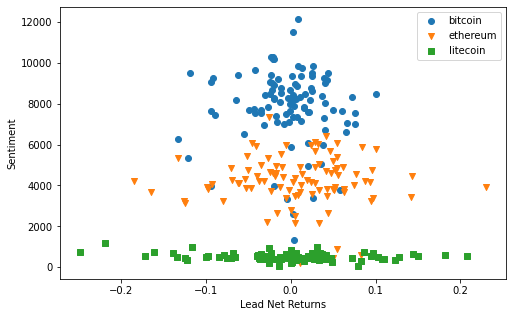

In [54]:
# Twitter
plt.figure(figsize = (8,5))
for i,j in zip(cryptos, markers):
    plt.scatter(df.loc[i]["leadnet"], df.loc[i]["sentiment_Twitter"], label = i, marker=j)

# plt.title("Log returns vs Twitter Sentiment")
plt.xlabel("Lead Net Returns")
plt.ylabel("Sentiment")
plt.legend()
plt.savefig("Figures/leadreturns_twittersentiment.png", transparent = True)
plt.show()

For Twitter sentiment:

    - The average setiment of BTC is the biggest one, with a normal distribution along the 0.
    - The sentiment of LTc is the lowest, and most disperse, more outliers are seen.
    - ETH and BTC have a normal distribution.

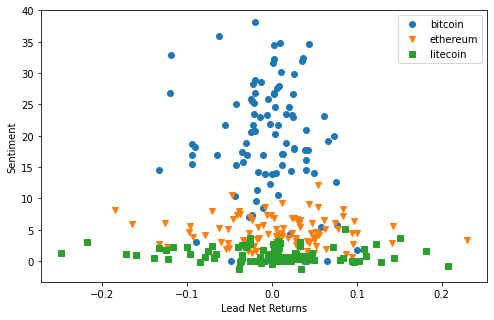

In [55]:
# Reddit
plt.figure(figsize = (8,5))
for i,j in zip(cryptos, markers):
    plt.scatter(df.loc[i]["leadnet"], df.loc[i]["title_sentiment_Reddit"], label = i, marker=j)

# plt.title("Log returns vs Reddit Title Sentiment")
plt.xlabel("Lead Net Returns")
plt.ylabel("Sentiment")
plt.legend()
plt.savefig("Figures/leadreturns_redditsentiment.png", transparent = True)
plt.show()

For Reddit sentiments:

    - Conclusions from Twitter are kept.
    - LTC is the most disperse, and with the lowest average sentiment.
    - BTC has the highest average sentiment.


## 2. Correlation

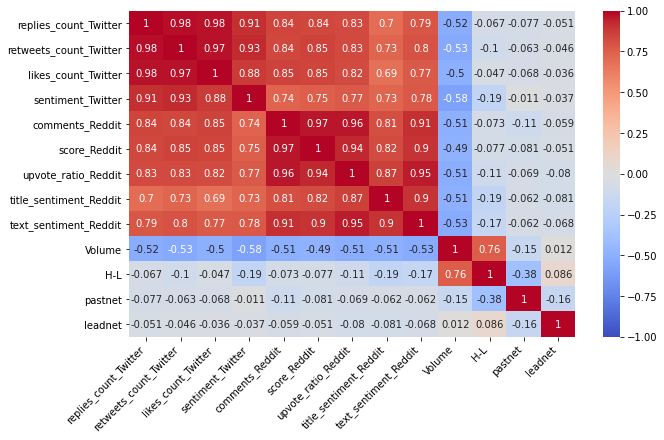

In [56]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(10,6)) 
sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  horizontalalignment='right')
plt.savefig("Figures/correlacion.png", transparent = True)

In the previouse figure it is observed:

    - Variables from Twitter are stongly correlated between them.
    - Variables from Reddit are strongly correlated between them.
    - None of them showed a stron correlation with the crypto variables, expect for volume.
    - Volume has a negative semi-strong correlation with the social media variables.
    - The H-O is strongly correlated with the volume. More transactions rise prices, and increase the difference between the highest and lowest price.


## 3. Multicollinearity

When we talk about multicollinearity, we talk about perfect multicollinearity, which refers to the linear relation between predictors.
The Variance Inflation Factor is applied, with a threshold of 10. After this threshold, the variable is said to be highly correlated with another independent variable.

In [57]:
aux = df.drop(columns = ['leadnet'])
t = []
for i in range(len(aux.columns)):
    v = vif(np.matrix(aux),i)

    t.append([ aux.columns[i],round(v,2) ])
        
t = pd.DataFrame(t)
t.columns = ["Feature", "VIF"]
t.set_index("Feature", inplace = True)
t

,VIF
Feature,
replies_count_Twitter,75.42
retweets_count_Twitter,81.00
likes_count_Twitter,55.93
sentiment_Twitter,24.84
comments_Reddit,50.67
score_Reddit,27.73
upvote_ratio_Reddit,44.79
title_sentiment_Reddit,10.41
text_sentiment_Reddit,30.43


There can be multicollinearity and no correlation.

The problem with multicollinearity in a regression model is that some regression models assume that the independent variables are INDEPENDENT.

There can be a moderated multicollinearity. if an isolated experiment is carried out, and the error metrics have good ranges, then, there is no need to remove them.

Multicollinearity is removed in an iterative process, where the greatest VIF value (above the threshold) variables is eliminated, all this until our model has no varible with a VIF value above the threshold.

In [58]:
# Iterativamente quitamos las que no queremos
max_i = []

while True:
    aux = df.drop(columns = ['leadnet'] + max_i)

    attributes = []
    ninguno = True
    max_i_aux = None
    max = 0

    for i in range(len(aux.columns)):
        v = vif(np.matrix(aux),i)

        if max < v:
            max = v
            max_i_aux = aux.columns[i] 

        if v > 10:
            ninguno = False

    if ninguno:
        break

    print("The highest was {} with {}".format(max_i_aux, max))
    max_i.append(max_i_aux)


The highest was retweets_count_Twitter with 80.99939430660491
The highest was replies_count_Twitter with 63.87591091288591
The highest was comments_Reddit with 50.081037172973744
The highest was upvote_ratio_Reddit with 32.503938919245655
The highest was text_sentiment_Reddit with 17.416745758022003
The highest was likes_count_Twitter with 14.80268414699235
The highest was H-L with 10.634332526346423


In [59]:
aux = df.drop(columns = ['leadnet'] + max_i)
t1 = []
for i in range(len(aux.columns)):
    v = vif(np.matrix(aux),i)

    t1.append([ aux.columns[i],round(v,2) ])
  
t1 = pd.DataFrame(t1)
t1.columns = ["Feature", "VIF1"]
t1.set_index("Feature", inplace = True)
t1

,VIF1
Feature,
sentiment_Twitter,4.86
score_Reddit,5.90
title_sentiment_Reddit,5.89
Volume,1.17
pastnet,1.03


In [60]:
# Latex help for paper
tt = pd.concat([ t, t1 ], axis = 1)
tt.fillna("-", inplace = True)
print(tt.to_latex(index = True))

\begin{tabular}{lrl}
\toprule
{} &    VIF &  VIF1 \\
Feature                &        &       \\
\midrule
replies\_count\_Twitter  &  75.42 &     - \\
retweets\_count\_Twitter &  81.00 &     - \\
likes\_count\_Twitter    &  55.93 &     - \\
sentiment\_Twitter      &  24.84 &  4.86 \\
comments\_Reddit        &  50.67 &     - \\
score\_Reddit           &  27.73 &   5.9 \\
upvote\_ratio\_Reddit    &  44.79 &     - \\
title\_sentiment\_Reddit &  10.41 &  5.89 \\
text\_sentiment\_Reddit  &  30.43 &     - \\
Volume                 &   9.17 &  1.17 \\
H-L                    &  12.11 &     - \\
pastnet                &   1.30 &  1.03 \\
\bottomrule
\end{tabular}



Multicollinearity has been managed. 

In summary:

    - Information from social media, apart from sentiment was eliminated (expect for Reddit posts scores).

In [61]:
# Eliminate variables
eliminate = max_i

df.drop(columns = eliminate, inplace = True)

df.head()

,,sentiment_Twitter,score_Reddit,title_sentiment_Reddit,Volume,pastnet,leadnet
crypto,index,,,,,,
ethereum,2021-02-28,3259.952393,3553.0,0.6447,1.319665e+06,0.052923,0.094095
bitcoin,2021-03-01,7987.280372,0.0,0.0000,8.470644e+04,0.058134,-0.001092
ethereum,2021-03-01,3732.452688,1022.0,1.3707,1.117555e+06,0.094095,-0.023344
bitcoin,2021-03-02,7641.111772,0.0,0.0000,5.967005e+04,-0.001092,-0.000817
ethereum,2021-03-02,3794.395788,3884.0,7.2760,9.918913e+05,-0.023344,-0.001590


[Text(0.5, 0, 'sentiment_Twitter'),
 Text(1.5, 0, 'score_Reddit'),
 Text(2.5, 0, 'title_sentiment_Reddit'),
 Text(3.5, 0, 'Volume'),
 Text(4.5, 0, 'pastnet'),
 Text(5.5, 0, 'leadnet')]

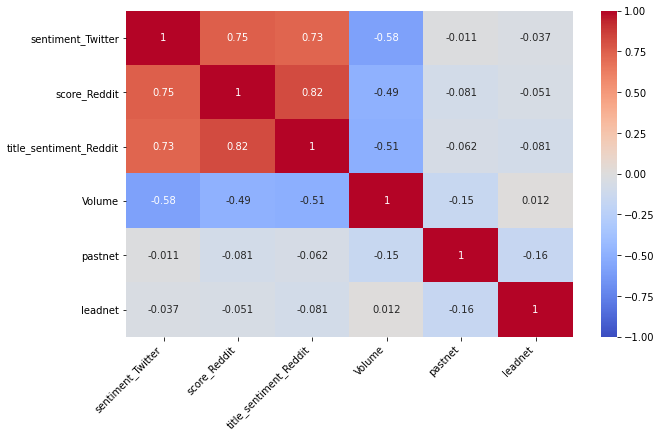

In [62]:
# Correlation is plotted again
corr = df.corr()

fig, ax = plt.subplots(figsize=(10,6)) 
sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  horizontalalignment='right')

## 4. Homoskedasticity

Homoskedasticity is when certain random variables have a finite variance (also called homogeneity of variance).

Homoskedasticity is when the variance of the residuals (error terms) in a regression are constant. They do not vary as much as the predictors (independent variables).
If there is no homoskedasticity, it means that the model needs to include more predictor variables to explain the dependent variable.

If there is no Homoskedasticity, it is called Heteroskedasticity.

In [63]:
exog_vars = list( df.drop(columns = ["leadnet"]).columns )
exog = sm.add_constant(df[exog_vars])

In [64]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df[exog_vars])
df[exog_vars] = scaler.transform(df[exog_vars])

In [65]:
# Pooles OLS Model
from linearmodels.panel import PooledOLS

mod = PooledOLS(df["leadnet"], exog)
pooled_res = mod.fit(cov_type='clustered', cluster_entity=True)

# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooled_res.predict().fitted_values
residuals_pooled_OLS = pooled_res.resids

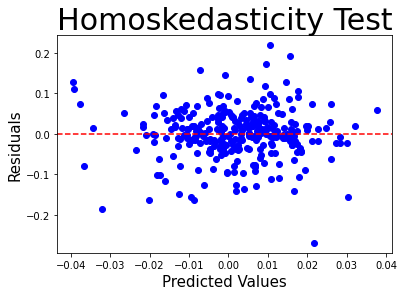

In [66]:
# Homoskedasticity
import matplotlib.pyplot as plt

# Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

In [67]:
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([df, residuals_pooled_OLS], axis=1)
exog = sm.tools.tools.add_constant(df[exog_vars]).fillna(0)

aux = []

# White-Test
white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print("White test:\n",dict(zip(labels, white_test_results)))

aux.append([ "White test"] +  list(white_test_results) )

# Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print("\nBreusch-Pagan test:\n",dict(zip(labels, breusch_pagan_test_results)))

aux.append(["Breusch-Pagan test"]  + list(breusch_pagan_test_results))

aux = pd.DataFrame(aux)

White test:
 {'LM-Stat': 54.649236653647776, 'LM p-val': 4.632114002622076e-05, 'F-Stat': 3.119843164676757, 'F p-val': 1.4581724243247634e-05}

Breusch-Pagan test:
 {'LM-Stat': 35.77652252184461, 'LM p-val': 1.0527553538109835e-06, 'F-Stat': 7.986844563937281, 'F p-val': 4.5929452054998497e-07}


In [68]:
# Latex help
aux.columns = ["Test", "LM T-stat", "LM P-value", "F T-stat", "F P-value"]
aux = aux.round(decimals = 3)
print(aux.to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
              Test &  LM T-stat &  LM P-value &  F T-stat &  F P-value \\
\midrule
        White test &     54.649 &         0.0 &     3.120 &        0.0 \\
Breusch-Pagan test &     35.777 &         0.0 &     7.987 &        0.0 \\
\bottomrule
\end{tabular}



For both tests, the p-value is way below the 5% significance level, by which we reject the null hypothesis, demonstrating the lacking of homoskedasticity, and finding heteroskedasticity.

In the absence of homoskedasticity, it can be said that our hypothesis lacks more variables to predict the returns of cryptos. Market information, and average sentiments from Twitter and Reddit are not enough.
So information regarding other market data could be important.

Still, by no dealing with multicollinearity, the remaining variables are not reintegrated.

## 5. Endogeneity

Its null hypothesis is that the covariance between the independent variables and alpha is equal to 0, that is, if its p-value is less than 5% the null hypothesis is rejected, the covariance is not equal to 0 and there is endogeneity in our model.
So we want to accept the null hypothesis, to indicate that the covariance is 0, and there is exogeneity in the model.

In [69]:
from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects

mod = PanelOLS(df["leadnet"], exog, entity_effects=True)
fe_res = mod.fit()

mod = RandomEffects(df["leadnet"], exog)
re_res = mod.fit()

In [70]:
import numpy.linalg as la
from scipy import stats

def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 
 
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(fe_res, re_res) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2].round(decimals = 3)) )

chi-Squared: 0.7671302471791315
degrees of freedom: 6
p-Value: 0.993


P-value is above the 5% significance level, we accept the null hypothesis that our variables are exogenous.

## 6. Normality, Skewness, Kurtosis

In [71]:
norm = pd.DataFrame()

In [72]:
aux = normality_test(df, mode="shapiro").round(decimals = 3)
norm["shapiro"] = aux["shapiro_Statistic"].astype(str) + aux["shapiro_Pvalue"].apply(lambda x: '^{***}$' if x < 0.01 else '^{**}$' if x < 0.05 else '^{*}$' if x < 0.1 else '')

In [73]:
aux = normality_test(df, mode="ks").round(decimals = 3)
norm["ks"] = aux["ks_Statistic"].astype(str) + aux["ks_Pvalue"].apply(lambda x: '^{***}$' if x < 0.01 else '^{**}$' if x < 0.05 else '^{*}$' if x < 0.1 else '')

In [74]:
aux = normality_test(df, mode="anderson").round(decimals = 3)
norm["anderson"] = aux["anderson_Statistic"].astype(str) + aux["anderson_Normality"].apply(lambda x: '^{***}$' if x == 1 else '^{**}$' if x ==5 else '^{*}$' if x == 10 else '')

### Skewness and Kurtosis

In [75]:
norm["skewness"] = df.skew(axis = 0)

In [76]:
norm["kurtosis"] = df.kurtosis(axis = 0)

In [77]:
norm

,shapiro,ks,anderson,skewness,kurtosis
sentiment_Twitter,0.905^{***}$,0.5^{***}$,9.274,0.233244,-1.228940
score_Reddit,0.755^{***}$,0.5^{***}$,28.654,1.530577,1.769825
title_sentiment_Reddit,0.8^{***}$,0.5^{***}$,22.667,1.310172,0.608176
Volume,0.812^{***}$,0.5^{***}$,11.772,2.095054,8.035176
pastnet,0.969^{***}$,0.571^{***}$,2.837,-0.337816,1.862531
leadnet,0.967^{***}$,0.43^{***}$,3.08,-0.322554,1.937535


According to normality tests, neither our Twitter nor Reddit sentiments show normality. Neither do the advanced returns.

    - For the Shapiro test, it is rejected at the 1% level since the info is Non-normal. It was desired to accept the null hypothesis.
    - For the Kolmogorov-Smirnov test, it is rejected at the 1% level, since the null hypothesis was to be accepted.
    - In the case of Anderson's test, the aim is to reject the null hypothesis, however, its p-value means that we cannot reject it. the test, however, its p-value means that we cannot reject it, so we accept it by saying that it does not have a normal distribution.

With regard to skewness, its symmetry:

    - Twitter's sentiments are very symmetric, being between -0.5 and 0.5.
    - Those of Reddit exceed 1, so they are very asymmetric (highly skewed).
    - For the return, it is less than -0.5, so it is moderately skewed.

For kurtosis, or the distribution of its tails:

    - Twitter's sentiments are less than 0, so they are platykurtic, i.e. they have few outliers.
    - Those of reddit are greater than 0, but very close to it, so although they are or could be considered Leptourtic, their number of outliers is moderate.
    - The returns are Leptokurtic, with many outliers and fat tails.

## 6. Stationarity and Unit Roots

In [78]:
urt = unit_root_test(df, adf_regression='ct', kpss_regression='ct')

urt = urt.astype(float).round(decimals= 3)

urt["ADF"] = urt["ADF_T-Statistic"].astype(str) + urt["ADF_P-Value"].apply(lambda x: '^{***}$' if x < 0.01 else '^{**}$' if x < 0.05 else '^{*}$')

urt["KPSS"] = urt["KPSS_T-Statistic"].astype(str) + urt["KPSS_P-Value"].apply(lambda x: '^{***}$' if x < 0.01 else '^{**}$' if x < 0.05 else '^{*}$')

urt = urt[["ADF", "KPSS"]]
urt

,ADF,KPSS
sentiment_Twitter,-6.652^{***}$,0.144^{*}$
score_Reddit,-3.791^{**}$,0.186^{**}$
title_sentiment_Reddit,-3.299^{*}$,0.303^{**}$
Volume,-2.767^{*}$,0.111^{*}$
pastnet,-5.801^{***}$,0.057^{*}$
leadnet,-7.208^{***}$,0.06^{*}$


From the stationarity and unit root tests, we observe:
    
    - KPSS fails to reject the hypothesis at the 5% level, but at the 10% level. If we are strict with a level of 5%, then the null hypothesis is accepted and the data is stationary.
    - ADF indicates that almost none of the social network data managed to reject its null hypothesis at 5%, so it shows unit roots. In this case the market data did, up to the 1% level, so it does NOT have unit roots.

## 7. Autocorrelation

In [79]:
aut = durbin_watson_test( df )
aut

,Durbin_Watson,Auto-Correlation
sentiment_Twitter,1.889250,False
score_Reddit,2.021583,False
title_sentiment_Reddit,2.004814,False
Volume,1.782038,False
pastnet,2.084553,False
leadnet,1.989253,False


In [80]:
statistical = pd.concat([norm, urt, aut], axis = 1)
statistical

,shapiro,ks,anderson,skewness,kurtosis,ADF,KPSS,Durbin_Watson,Auto-Correlation
sentiment_Twitter,0.905^{***}$,0.5^{***}$,9.274,0.233244,-1.228940,-6.652^{***}$,0.144^{*}$,1.889250,False
score_Reddit,0.755^{***}$,0.5^{***}$,28.654,1.530577,1.769825,-3.791^{**}$,0.186^{**}$,2.021583,False
title_sentiment_Reddit,0.8^{***}$,0.5^{***}$,22.667,1.310172,0.608176,-3.299^{*}$,0.303^{**}$,2.004814,False
Volume,0.812^{***}$,0.5^{***}$,11.772,2.095054,8.035176,-2.767^{*}$,0.111^{*}$,1.782038,False
pastnet,0.969^{***}$,0.571^{***}$,2.837,-0.337816,1.862531,-5.801^{***}$,0.057^{*}$,2.084553,False
leadnet,0.967^{***}$,0.43^{***}$,3.08,-0.322554,1.937535,-7.208^{***}$,0.06^{*}$,1.989253,False


## Prediction models
### Train-Test

In [81]:
train_size = int( len(df)*0.8 )
test_size = len(df) - train_size

train = df.iloc[:train_size]
test = df.iloc[-test_size:]

train_exog = sm.add_constant( train[exog_vars] )
test_exog = sm.add_constant( test[exog_vars] )

pred = pd.DataFrame(index = test.index)

### Panel Data

In [84]:
# Random effects
from linearmodels.panel import RandomEffects

# mod = RandomEffects( dff["net"], exog )
mod = RandomEffects( train["leadnet"], train_exog )

re_res = mod.fit()

pred["RE"] = re_res.predict(exog=test_exog)

In [85]:
# Pooles OLS Model
from linearmodels.panel import PooledOLS

mod = PooledOLS( train["leadnet"], train_exog )
pooled_res = mod.fit(cov_type='clustered', cluster_entity=True)

pred["PoolOLS"] = pooled_res.predict(exog=test_exog)

In [86]:
# Fixed Effects
from linearmodels.panel import PanelOLS

mod = PanelOLS(train["leadnet"], train_exog, entity_effects=True)
fe_res = mod.fit()

pred["FE"] = fe_res.predict(exog=test_exog)

### Machine Learning

k: 17


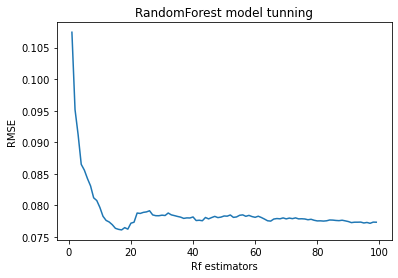

In [87]:
from sklearn.ensemble import RandomForestRegressor

# rf tunning

score = []
min = np.inf
for i in range(1,100):
    regr = RandomForestRegressor(n_estimators=i, random_state=1)
    regr = regr.fit(train[exog_vars], train["leadnet"])
    aux = regr.predict( test[exog_vars] ) 
    score.append([i, mean_squared_error( test['leadnet'] , aux, squared=False)])

score = pd.DataFrame(score)
score.columns = ["i", "rmse"]

i = int(score[ score["rmse"] == score["rmse"].min() ].iloc[0]["i"])

print("k:",i)

regr = RandomForestRegressor(n_estimators=i, random_state=1)
regr = regr.fit(train[exog_vars], train["leadnet"])

pred["RF"] = regr.predict( test[exog_vars] )

plt.plot(score["i"], score["rmse"])
plt.xlabel("Rf estimators")
plt.ylabel("RMSE")
plt.title("RandomForest model tunning")
plt.show()

i:15 	 j:0.1


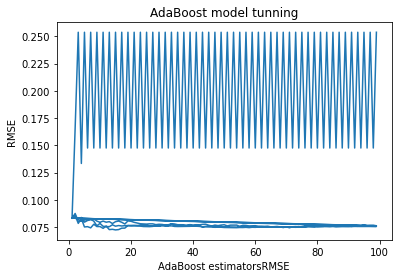

In [88]:
from sklearn.ensemble import AdaBoostRegressor

score = []

for j in [0.1, 0.5, 1, 10]:
    for i in range(1,100):
        regr = AdaBoostRegressor(random_state=1, n_estimators=i, learning_rate = j)
        regr = regr.fit(train[exog_vars], train["leadnet"])
        aux = regr.predict( test[exog_vars] ) 
        score.append([i, j, mean_squared_error( test['leadnet'] , aux, squared=False)])

score = pd.DataFrame(score)
score.columns = ["i", "j", "rmse"]

i = int(score[ score["rmse"] == score["rmse"].min() ].iloc[0]["i"])
j = float(score[ score["rmse"] == score["rmse"].min() ].iloc[0]["j"])

print("i:{} \t j:{}".format(i, j))

regr = regr = AdaBoostRegressor(random_state=1, n_estimators=i, learning_rate=j)
regr = regr.fit(train[exog_vars], train["leadnet"])

pred["AB"] = regr.predict( test[exog_vars] )

plt.plot(score["i"], score["rmse"])
plt.xlabel("AdaBoost estimatorsRMSE")
plt.ylabel("RMSE")
plt.title("AdaBoost model tunning")
plt.show()

k: 88 weigth: uniform


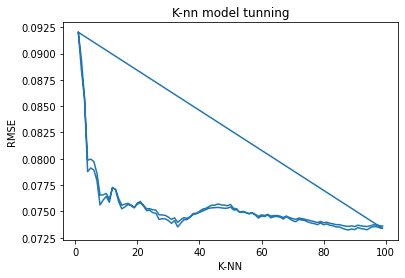

In [89]:
from sklearn.neighbors import KNeighborsRegressor

#knn tunning

score = []

for weigth in ["uniform", "distance"]:
    for i in range(1,100):
        regr = KNeighborsRegressor(n_neighbors=i, weights = weigth)
        regr = regr.fit(train[exog_vars], train["leadnet"])
        aux = regr.predict( test[exog_vars] ) 
        score.append([i, weigth, mean_squared_error( test['leadnet'] , aux, squared=False)])

score = pd.DataFrame(score)
score.columns = ["i", "weigth", "rmse"]

i = int(score[ score["rmse"] == score["rmse"].min() ].iloc[0]["i"])
weigth = score[ score["rmse"] == score["rmse"].min() ].iloc[0]["weigth"]

print("k:",i, "weigth:", weigth)

regr = KNeighborsRegressor(n_neighbors= i, weights = weigth)
regr = regr.fit(train[exog_vars], train["leadnet"])

pred["kNN"] = regr.predict( test[exog_vars] )

plt.plot(score["i"], score["rmse"])
plt.xlabel("K-NN")
plt.ylabel("RMSE")
plt.title("K-nn model tunning")
plt.show()

k: 14


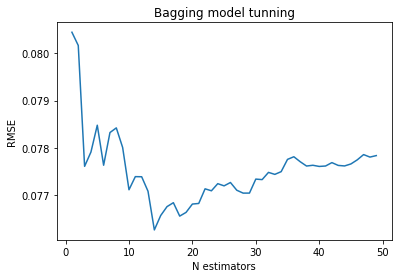

In [90]:
# Este tarda
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

score = []

for i in range(1,50):
    regr = BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=15, random_state=1), n_estimators=i, random_state=1)
    regr = regr.fit(train[exog_vars], train["leadnet"])
    aux = regr.predict( test[exog_vars] ) 
    score.append([i, mean_squared_error( test['leadnet'] , aux, squared=False)])

score = pd.DataFrame(score)
score.columns = ["i", "rmse"]

i = int(score[ score["rmse"] == score["rmse"].min() ].iloc[0]["i"])

print("k:",i)

regr = BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=15, random_state=1), n_estimators=i, random_state=1)
regr = regr.fit(train[exog_vars], train["leadnet"])

pred["bagging"] = regr.predict( test[exog_vars] )

plt.plot(score["i"], score["rmse"])
plt.xlabel("N estimators")
plt.ylabel("RMSE")
plt.title("Bagging model tunning")
plt.show()

identity
logistic
tanh
relu
k: 32 activation: relu solver: adam alpha: 0.001


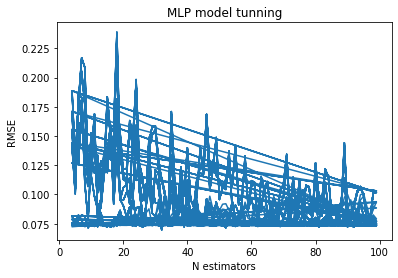

In [91]:
# MLP
from sklearn.neural_network import MLPRegressor

score = []

for activation in ["identity", "logistic", "tanh", "relu"]:
    print(activation)
    for solver in ["lbfgs", "sgd", "adam"]:
        for alpha in [0.0001, 0.00001, 0.001, 0.01]:
            for i in range(4,100):
                regr = MLPRegressor(random_state = 1, hidden_layer_sizes=i, activation = activation, solver = solver, alpha = alpha)
                regr = regr.fit(train[exog_vars], train["leadnet"])
                aux = regr.predict( test[exog_vars] ) 
                score.append([activation, solver, alpha, i, mean_squared_error( test['leadnet'] , aux, squared=False)])

score = pd.DataFrame(score)
score.columns = ["activation", "solver", "alpha", "i", "rmse"]

i = int(score[ score["rmse"] == score["rmse"].min() ].iloc[0]["i"])
alpha = float(score[ score["rmse"] == score["rmse"].min() ].iloc[0]["alpha"])
activation = score[ score["rmse"] == score["rmse"].min() ].iloc[0]["activation"]
solver = score[ score["rmse"] == score["rmse"].min() ].iloc[0]["solver"]

print("k:",i, "activation:", activation, "solver:", solver, "alpha:", alpha)

regr = MLPRegressor(random_state = 1, hidden_layer_sizes=i, activation = activation, solver = solver)
regr = regr.fit(train[exog_vars], train["leadnet"])

pred["MLP"] = regr.predict( test[exog_vars] )

plt.plot(score["i"], score["rmse"])
plt.xlabel("N estimators")
plt.ylabel("RMSE")
plt.title("MLP model tunning")
plt.show()

### Comparatives

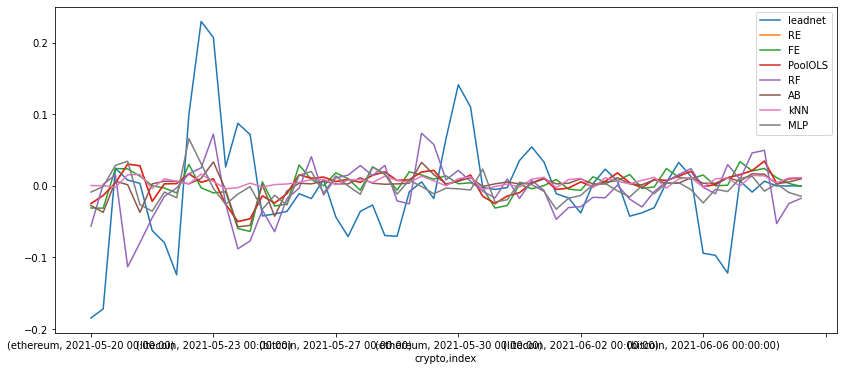

In [92]:
reg = ["leadnet", "RE", "FE", "PoolOLS", "RF", "AB", "kNN", "MLP"]

pred["leadnet"] = test["leadnet"]

pred.dropna(inplace = True)

pred[reg].plot(figsize = (14,6))

In [97]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

aux = []
for i in ["RE", "FE", "PoolOLS", "RF", "AB", "kNN", "MLP"]:
    aux.append([ i, mean_squared_error(pred['leadnet'], pred[i], squared=False), mean_absolute_error(pred['leadnet'], pred[i]) ])

aux = pd.DataFrame(aux)
aux.columns = ["name", "rmse", "mae"]
aux

,name,rmse,mae
0,RE,0.074021,0.053264
1,FE,0.075104,0.053324
2,PoolOLS,0.074021,0.053264
3,RF,0.076105,0.057463
4,AB,0.072493,0.051372
5,kNN,0.073239,0.051257
6,MLP,0.069772,0.048455


In [98]:
# Latex help
print(aux.round(decimals = 3).to_latex(index = False))

\begin{tabular}{lrr}
\toprule
   name &  rmse &   mae \\
\midrule
     RE & 0.074 & 0.053 \\
     FE & 0.075 & 0.053 \\
PoolOLS & 0.074 & 0.053 \\
     RF & 0.076 & 0.057 \\
     AB & 0.072 & 0.051 \\
    kNN & 0.073 & 0.051 \\
    MLP & 0.070 & 0.048 \\
\bottomrule
\end{tabular}



In [99]:
print("RMSE:\n", aux[ aux["rmse"] == aux["rmse"].min() ] )
print("\n")
print("MAE:\n", aux[ aux["mae"] == aux["mae"].min() ] )


best = aux[ aux["rmse"] == aux["rmse"].min() ].iloc[0]["name"]

best2 = aux[ aux["mae"] == aux["mae"].min() ].iloc[0]["name"]


RMSE:
   name      rmse       mae
6  MLP  0.069772  0.048455


MAE:
   name      rmse       mae
6  MLP  0.069772  0.048455


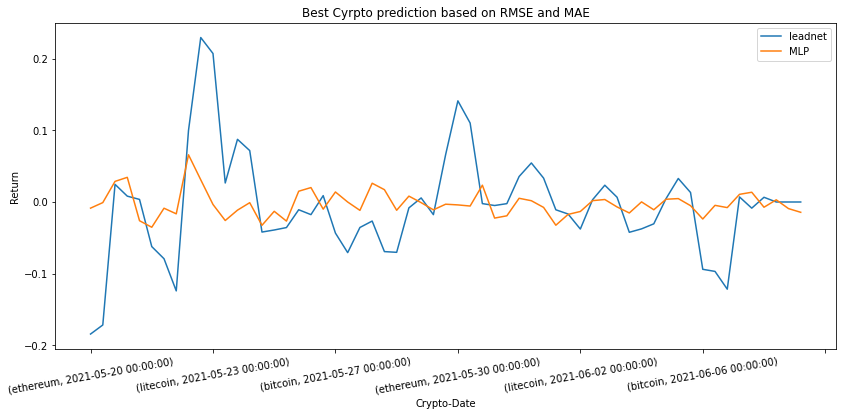

In [100]:
pred[["leadnet", best]].plot(figsize = (14,6))
plt.title("Best Cyrpto prediction based on RMSE and MAE")
plt.ylabel("Return")
plt.xlabel("Crypto-Date")
plt.xticks(rotation = 10)
plt.savefig("Figures/best_prediction.png", transparent = True)